# House Prices - Advanced Regression Techniques

In this project, we predict the sale prices of homes based on a rich set of explanatory variables describing almost every aspect of residential homes. 
This will allow us to use the model to determine fair the market value of homes on the market based on specific attributes.

This is a **Supervised Learning - Regression** problem. 

Goals:
- Conduct thorough EDA (Exploratory Data Analysis)
- Clean and preprocess the data
- Train and optimize three different regression models
- Compare model performance and draw conclusions

#Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score


# -- Load Data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# Exploratory Data Analysis (EDA)
We first inspect the dataset for:
- Missing values
- Data types
- Basic statistics
- Outliers and distributions

(1460, 81)


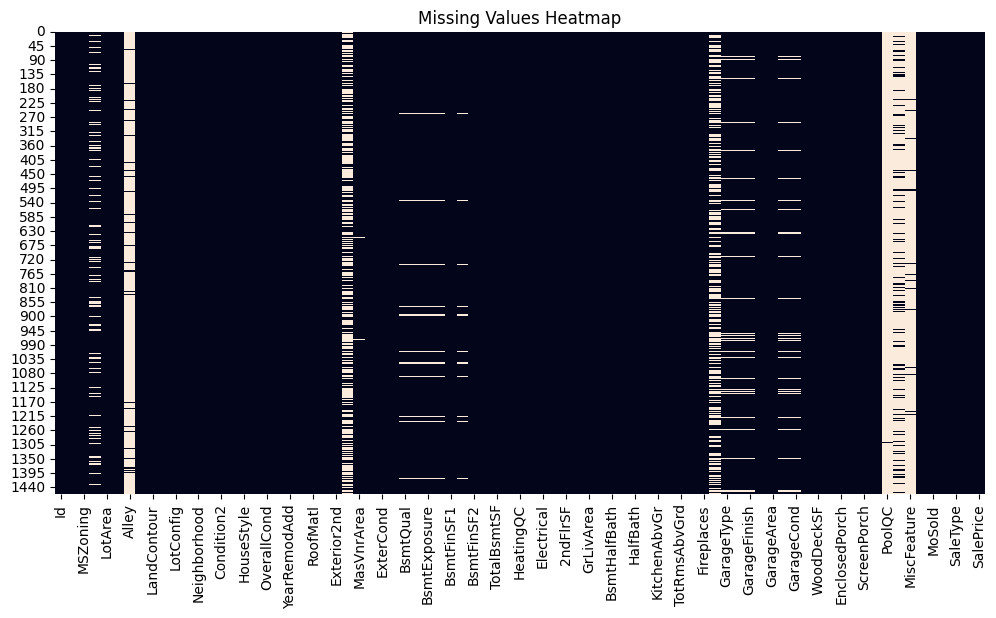

In [6]:
# Basic Info
print(train.shape)
train.head()

# Summary Statistics
train.describe()

# Check missing values
missing = train.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

# Visualize missing values
plt.figure(figsize=(12,6))
sns.heatmap(train.isnull(), cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

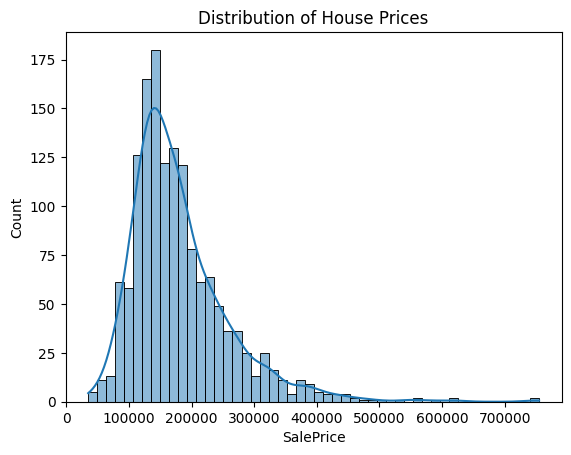

In [7]:
sns.histplot(train["SalePrice"], kde=True, bins=50)
plt.title("Distribution of House Prices")
plt.show()

In [8]:
categorical_cols = train.select_dtypes(include=["object"]).columns
print("Categorical columns:", categorical_cols)

Categorical columns: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [9]:
# Fill missing numerical values with median
num_features = train.select_dtypes(include=[np.number]).columns
for feature in num_features:
    train[feature] = train[feature].fillna(train[feature].median())

# Fill missing categorical values with mode
cat_features = train.select_dtypes(include=[object]).columns
for feature in cat_features:
    train[feature] = train[feature].fillna(train[feature].mode()[0])

# Log-transform target (SalePrice is skewed)
train['SalePrice'] = np.log1p(train['SalePrice'])

# Label Encode Categorical Variables
label_encoder = LabelEncoder()
for feature in cat_features:
    train[feature] = label_encoder.fit_transform(train[feature])


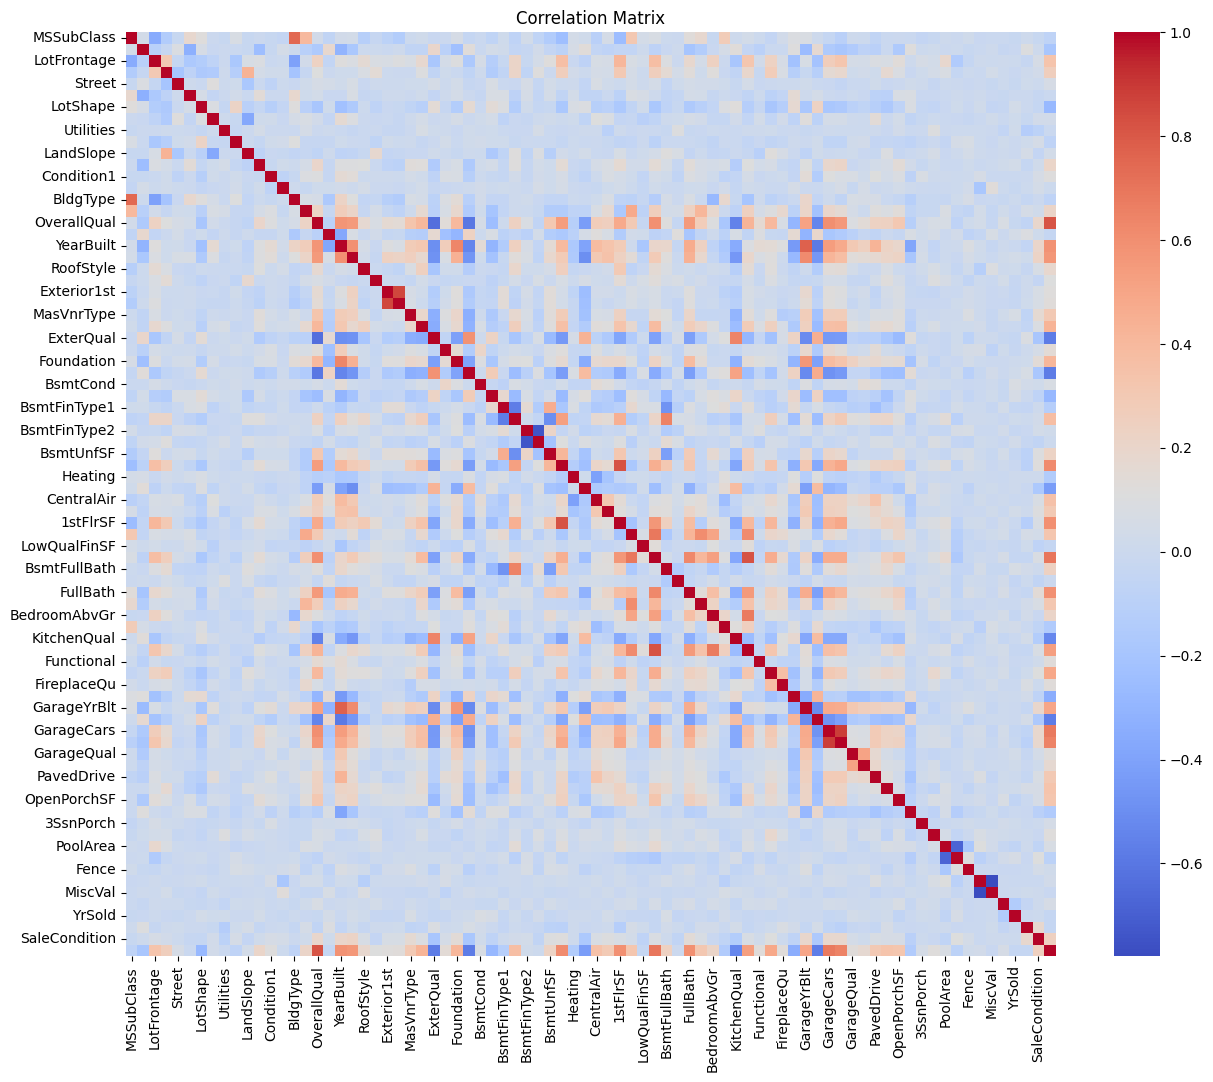

SalePrice       1.000000
OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
Name: SalePrice, dtype: float64

In [10]:
# Correlation Heatmap
plt.figure(figsize=(15,12))
correlation = train.drop(['Id'], axis=1).corr()
sns.heatmap(correlation, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Top correlated features with SalePrice
corr_with_saleprice = correlation['SalePrice'].sort_values(ascending=False)
corr_with_saleprice.head(10)

In [11]:
X = train.drop(['SalePrice', 'Id'], axis=1)
y = train['SalePrice']

# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test Split
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Feature Selection
We use Lasso regression for feature selection to remove irrelevant or less important features.

In [12]:
# Apply Lasso for feature selection
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
model = SelectFromModel(lasso, prefit=True)

X_train_selected = model.transform(X_train)
X_valid_selected = model.transform(X_valid)

print(f"Original feature set: {X_train.shape[1]} features")
print(f"Reduced feature set: {X_train_selected.shape[1]} features")

X_train = X_train_selected
X_valid = X_valid_selected

Original feature set: 79 features
Reduced feature set: 33 features


# Model Building and Tuning
We train three models:
- Linear Regression
- Ridge Regression
- Random Forest Regressor

We also optimize hyperparameters for Ridge and Random Forest models.

In [ ]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_valid)

# Ridge Regression with Hyperparameter Tuning
ridge = Ridge()
params_ridge = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge_cv = GridSearchCV(ridge, params_ridge, cv=5)
ridge_cv.fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_valid)

# Random Forest Regressor with Hyperparameter Tuning
rf = RandomForestRegressor(random_state=42)
params_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
rf_cv = GridSearchCV(rf, params_rf, cv=5)
rf_cv.fit(X_train, y_train)
y_pred_rf = rf_cv.predict(X_valid)

# Model Performance Comparison
We evaluate models using:
- Root Mean Squared Error (RMSE)
- R² Score

Lower RMSE and higher R² indicate better performance.

In [ ]:
# Evaluation Function
def evaluate(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {'Model': model_name, 'RMSE': rmse, 'R2': r2}

# Collect results
results = []
results.append(evaluate(y_valid, y_pred_lr, 'Linear Regression'))
results.append(evaluate(y_valid, y_pred_ridge, 'Ridge Regression (Tuned)'))
results.append(evaluate(y_valid, y_pred_rf, 'Random Forest (Tuned)'))

results_df = pd.DataFrame(results)
print(results_df)

                      Model      RMSE        R2
0         Linear Regression  0.149448  0.880313
1  Ridge Regression (Tuned)  0.149828  0.879704
2     Random Forest (Tuned)  0.141104  0.893305


# Cross-Validation
Assess model stability using 5-fold Cross-Validation on training data.

In [ ]:
# Cross Validation
cv_scores = {
    'Linear Regression': np.mean(cross_val_score(lr, X_train_selected, y_train, cv=5, scoring='r2')),
    'Ridge Regression': np.mean(cross_val_score(ridge_cv.best_estimator_, X_train_selected, y_train, cv=5, scoring='r2')),
    'Random Forest': np.mean(cross_val_score(rf_cv.best_estimator_, X_train_selected, y_train, cv=5, scoring='r2'))
}

# Display CV Scores
cv_results = pd.DataFrame(list(cv_scores.items()), columns=['Model', 'Cross-Validation R2'])
print(cv_results)


               Model  Cross-Validation R2
0  Linear Regression             0.850076
1   Ridge Regression             0.854766
2      Random Forest             0.862335


# Results Visualization
Visualize the true vs predicted values.

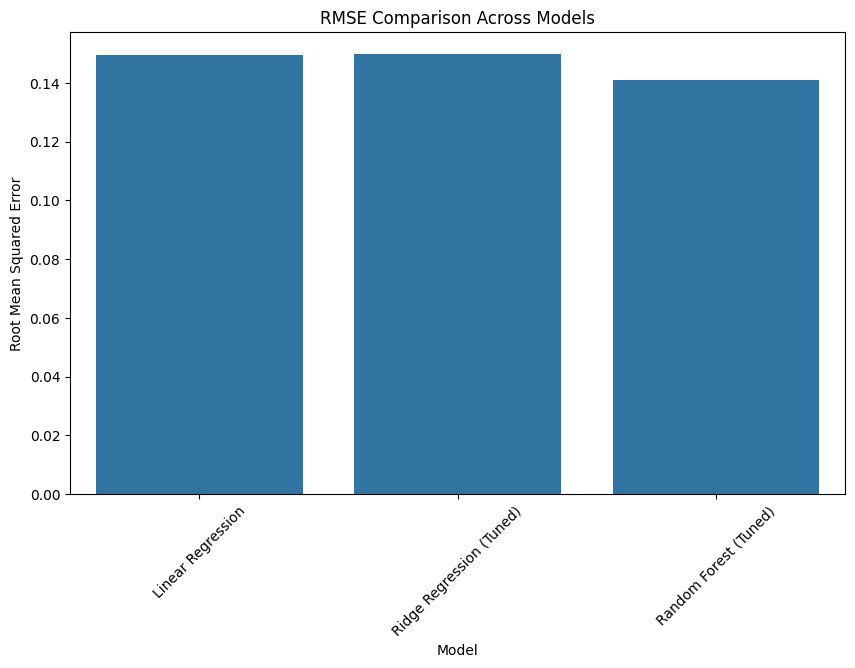

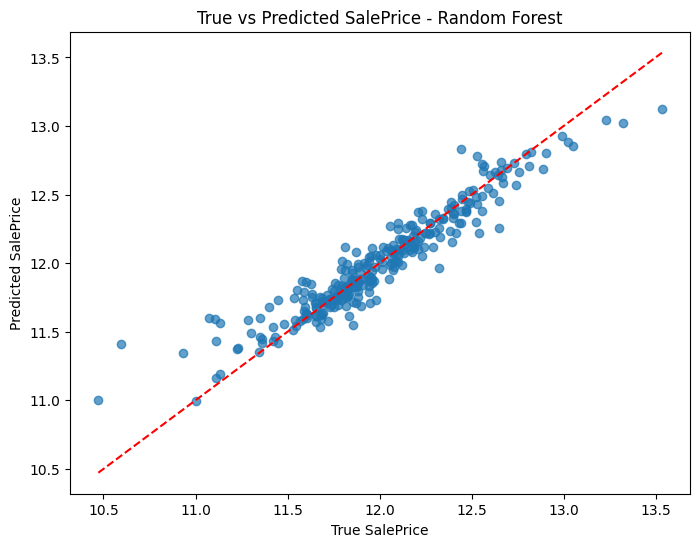

In [ ]:
# Bar Plot of RMSE
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='RMSE', data=results_df)
plt.title('RMSE Comparison Across Models')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

# Plot True vs Predicted for Best Model (Example: Random Forest)
plt.figure(figsize=(8,6))
plt.scatter(y_valid, y_pred_rf, alpha=0.7)
plt.xlabel('True SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('True vs Predicted SalePrice - Random Forest')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], '--r')
plt.show()

# Conclusion
- All three models performed reasonably well, but Random Forest Regressor outperformed others.
- Hyperparameter tuning significantly improved Ridge and Random Forest performance.
- Feature scaling and handling missing values were crucial for reliable model performance.

**Next Steps for Improvement:**
- Further feature engineering (interaction terms, polynomial features).
- Ensemble methods (stacking multiple models).
- Feature selection to remove noise.

This project demonstrates the typical workflow for tackling a real-world supervised regression problem, from data cleaning to model comparison and evaluation.